In [500]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/twin-polyak


In [501]:
%load_ext autoreload
%autoreload 2

import os
import datetime
import time
from collections import defaultdict
import pickle

import numpy as np
import numba

import matplotlib.pyplot as plt

from experiments import utils
from experiments.loss_functions import LogisticRegressionLoss, BaseOracle
from experiments.methods import *

import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import scipy
import svmlight_loader

from dotenv import load_dotenv
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [316]:
np.random.seed(0)
n = 2000
d = 50
dataset_name = "synthetic-interpolation"
data, target = utils.make_synthetic_binary_classification(n, d)
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=0)

L = (0.25 / train_data.shape[0]) * np.linalg.norm(train_data.T.dot(train_data), ord=2)
dataset = train_data, train_target, test_data, test_target

batch_size = train_data.shape[0]

print(f"{L=}")
print(f"{1/L=}")

dataset = train_data, train_target, test_data, test_target

L=0.3376891311044958
1/L=2.961303482671334


In [582]:
np.random.seed(0)
n = 2000
d = 100
dataset_name = "synthetic-interpolation"

data, target = make_classification(n_samples=n, n_features=d, n_redundant=0, n_clusters_per_class=1, class_sep=3.0, random_state=0)
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=0)

train_target = utils.map_classes_to(train_target, [-1.0, 1.0])
test_target = utils.map_classes_to(test_target, [-1.0, 1.0])

L = (0.25 / train_data.shape[0]) * np.linalg.norm(train_data.T @ train_data, ord=2)

batch_size = train_data.shape[0]
# batch_size = 100

print(f"{L=}")
print(f"{1/L=}")
print(f"{np.unique(train_target)=}")

dataset = train_data, train_target, test_data, test_target

L=2.389895931489896
1/L=0.4184282615923721
np.unique(train_target)=array([-1.,  1.])


In [588]:
np.random.seed(0)
n = 2000
d = 100
dataset_name = "synthetic-no-interpolation"

data, target = make_classification(n_samples=n, n_features=d, n_redundant=0, n_clusters_per_class=2, class_sep=0.1, random_state=0)
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=0)

train_target = utils.map_classes_to(train_target, [-1.0, 1.0])
test_target = utils.map_classes_to(test_target, [-1.0, 1.0])


L = (0.25 / train_data.shape[0]) * np.linalg.norm(train_data.T.dot(train_data), ord=2)

# batch_size = train_data.shape[0]
batch_size = 100

print(f"{L=}")
print(f"{1/L=}")
print(f"{np.unique(train_target)=}")

dataset = train_data, train_target, test_data, test_target

L=0.3813798712150801
1/L=2.622057626727887
np.unique(train_target)=array([-1.,  1.])


In [663]:
dataset_name = "a1a"
train_data, train_target, test_data, test_target = utils.get_libsvm(dataset_name, test_split=0.0)

# normalizer = sklearn.preprocessing.Normalizer()
# train_data = normalizer.fit_transform(train_data)
# test_data = normalizer.transform(test_data)

L = (0.25 / train_data.shape[0]) * scipy.sparse.linalg.norm(train_data.T @ train_data, ord=2)
train_target = utils.map_classes_to(train_target, [-1.0, 1.0])
test_target = utils.map_classes_to(test_target, [-1.0, 1.0])

batch_size = train_data.shape[0]
# batch_size = 64

print(f"{1/L=}")
print(f"{batch_size=}")
print(f"{train_data.shape=}, {test_data.shape=}")
print(f"{np.unique(train_target)=}, {np.unique(test_target)=}")
print(f"{scipy.sparse.linalg.norm(train_data[0])=}")

dataset = train_data, train_target, test_data, test_target

with open(f"experiments/solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    
train_f_star, train_x_star, test_f_star, test_x_star = b["train/f_star"], b["train/x_star"], b["test/f_star"], b["test/x_star"]
print(f"{train_f_star=}")
print(f"{test_f_star=}")

1/L=0.63809795026046
batch_size=1605
train_data.shape=(1605, 123), test_data.shape=(30956, 123)
np.unique(train_target)=array([-1.,  1.]), np.unique(test_target)=array([-1.,  1.])
scipy.sparse.linalg.norm(train_data[0])=3.7416573867739413
train_f_star=0.2978790702124984
test_f_star=0.3219226261481673


In [664]:
def moving_average(data, window_width):
    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    return ma_vec

def plotter(histories, labels, colors=None, linestyles=None, 
            linewidths=None, markers=None, markeredgecolor=None, markersize=8,
            alphas=None, f_star=None, suptitle=None, prefix="train",
            x_labels=None, y_labels=None,
            threshold=1e-10, xlims=None, tight_layout=True, filename=None):
    
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for x in histories]
    
    if linewidths is None:
        linewidths = [1.5 for x in histories]
        
    if markers is None:
        markers = [" " for x in histories]
    
    if alphas is None:
        alphas = [1.0 for x in histories]
        
    # if f_star is None:
    #     f_star = np.min([x["loss"] for x in histories])
    # else:
    #     f_star = np.min([f_star for x in histories])
    
    for history, label, c, ls, lw, m, alpha in zip(histories, labels, colors, linestyles, linewidths, markers, alphas):
        if not f_star:
            f_suboptim = history[f"{prefix}/loss"]
        else:
            f_suboptim = history[f"{prefix}/loss"] - f_star
            
        try:
            markevery = [0, ] + [x + np.random.randint(0, 5) for x in range(0, len(history[f"{prefix}/loss"]) - 5, len(history[f"{prefix}/loss"]) // 10)]
        except:
            markevery = []
        
        ax[0].semilogy(f_suboptim, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        ax[1].semilogy(history[f"{prefix}/grad_norm_sq"], linestyle=ls, linewidth=lw, color=c, label=label, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        ax[2].plot(history[f"{prefix}/acc"], linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        
        try:
            markevery = [0, ] + [x + np.random.randint(0, 5) for x in range(0, len(history["lr"]) - 5, len(history["lr"]) // 10)]
        except:
            markevery = []
        
        if alpha != 1.0:
            ax[3].semilogy(history["lr"], linestyle=ls, linewidth=lw, color=c, alpha=alpha)
            ax[3].semilogy(moving_average(history["lr"], 100), linestyle=ls, linewidth=lw, color=c, alpha=1.0, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        else:
            ax[3].semilogy(history["lr"], linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)

    if f_star == 0.0:
        ax[0].set_ylabel(r"$f(x_k)$")
        ax[1].set_ylabel(r"$\| \nabla f(x_k) \|^2$")
    else:
        ax[0].set_ylabel(r"$f(x_k) - f^*$")
        ax[1].set_ylabel(r"$\| \nabla f(x_k) \|^2$")
        
    ax[2].set_ylabel("Accuracy")
    ax[3].set_ylabel("step-size")
    
    ax[0].set_xlabel("Epochs")
    ax[1].set_xlabel("Epochs")
    ax[2].set_xlabel("Epochs")
    ax[3].set_xlabel("Steps")
    
    ax[3].tick_params(axis='x', rotation=45)


    if xlims is not None:
        ax[1].set_xlim(right=xlims[1])
    
    fig.legend()
    # # Put a legend below current axis
    # fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
    #       fancybox=True, shadow=True, ncol=len(histories))
    
    
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    ax[3].grid()

    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        directory = "experiments/plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
        if not os.path.exists(directory):
            os.makedirs(directory)
        fig.savefig(directory + "/" + filename)
    else:
        fig.show()

In [665]:
def train_loop(dataset: list[np.ndarray], 
               batch_size: int, 
               n_epochs: int,
               optimizer: BaseOptimizer,
               seed: int = 0,
               **optimizer_kwargs) -> dict: 

    np.random.seed(seed)

    train_data, train_target, test_data, test_target = dataset
    
    # params = np.zeros(train_data.shape[1])
    params = np.random.randn(train_data.shape[1])
    
    optim = optimizer(params, **optimizer_kwargs)

    # oracle 
    loss_function = LogisticRegressionLoss(lmd=0.0)
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    # Train Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params, train_data, train_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["train/loss"].append(loss)
    history["train/acc"].append(acc)
    history["train/grad_norm_sq"].append(g_norm_sq)

    # Test Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params, test_data, test_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["test/loss"].append(loss)
    history["test/acc"].append(acc)
    history["test/grad_norm_sq"].append(g_norm_sq)
    
    for epoch in range(n_epochs):

        # Training 
        if batch_size != train_data.shape[0]: # If full batch then don't shuffle indices
            np.random.shuffle(indices)

        for idx in range(train_data.shape[0]//batch_size):

            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
        
            train_loss, train_grad, train_acc = loss_function.func_grad_acc(params, batch_data, batch_target)
            
            if optim.__class__.__name__ == "SLS":
                def closure(params):
                    return loss_function.func(params, batch_data, batch_target)
                optim.step(loss=train_loss, grad=train_grad, closure=closure)
            else:
                optim.step(loss=train_loss, grad=train_grad)
            
            g_norm_sq = np.linalg.norm(train_grad)**2
            history["train/batch/loss"].append(train_loss)
            history["train/batch/acc"].append(train_acc)
            history["train/batch/grad_norm_sq"].append(g_norm_sq)  

            history["lr"].append(optim.lr)


        # Train Evaluation 
        loss, grad, acc = loss_function.func_grad_acc(params, train_data, train_target)
        g_norm_sq = np.linalg.norm(grad)**2
        history["train/loss"].append(loss)
        history["train/acc"].append(acc)
        history["train/grad_norm_sq"].append(g_norm_sq)

        # Test Evaluation 
        loss, grad, acc = loss_function.func_grad_acc(params, test_data, test_target)
        g_norm_sq = np.linalg.norm(grad)**2
        history["test/loss"].append(loss)
        history["test/acc"].append(acc)
        history["test/grad_norm_sq"].append(g_norm_sq)
        
    return history

In [666]:
class SPS_MA(BaseOptimizer):
    
    def __init__(self, params: np.ndarray, 
                 c: float = 0.5, 
                 eps: float = 1e-8,
                 eta_max: float = 0.0,
                 betas: tuple[float, float] = (0.9, 0.9)):
        
        self.params = params
        self.lr = 1.0
        self.eps = eps
        self.c = c
        self.betas = betas
        self.eta_max = eta_max
        
        self.defaults = dict(
            lr=1.0,
            c=c,
            eps=eps,
            )
        
        self._step_t = 0
        
        self.sum_f = 0.0
        self.sum_g = np.zeros_like(self.params)
        
    def step(self, loss, grad):
        
        self._step_t += 1
        
        self.sum_f = self.betas[0] * self.sum_f + (1 - self.betas[0]) * loss
        self.sum_g = self.betas[1] * self.sum_g + (1 - self.betas[1]) * grad
        # sum_hat = self.sum_g / (1 - self.beta**self._step_t)

        self.lr = self.sum_f / ( self.c * np.linalg.norm(self.sum_g)**2 + self.eps )        
        self.params -= self.lr * grad
            
        return loss, grad
    
    
class SLS(BaseOptimizer):
    
    def __init__(self, params: np.ndarray, 
                 lr_max: float = 1.0, 
                 gamma: float = 0.9, 
                 c: float = 0.1, 
                 verbose: bool = False):
        
        self.params = params
        self.gamma = gamma
        self.c = c
        self.lr_max = lr_max
        self.lr = lr_max
        self.verbose = verbose
        
        self.defaults = dict(
            lr_max=lr_max,
            gamma=gamma,
            c=c,
            verbose=verbose
            )
        
        self.adaptive_search_max_iter = 200
        
    def step(self, loss, grad, closure) -> np.ndarray:
        """Performs a single optimization step.

        Args:
            closure (Callable): closure.

        Returns:
            np.ndarray:  model parameters after performing optimization step.
        """
        
        d = -1.0 * grad
        self.lr = self.lr_max

        for j in range(1, self.adaptive_search_max_iter + 1):
            if j == self.adaptive_search_max_iter:
                if self.verbose:
                    print(('Warning: adaptive_iterations_exceeded'), flush=True)
                break
            
            new_params = self.params + self.lr * d
            new_loss = closure(new_params)
            
            lhs = new_loss
            rhs = loss + self.lr * self.c * d.dot(grad)
            
            if lhs <= rhs:
                if self.verbose:
                    print(f"Armijo backtracking took {j} steps: lr={self.lr}")
                break
            
            self.lr *= self.gamma
                

        # Update the parameters
        self.params += self.lr * d

        return loss, grad
    
class TwinPolyak(BaseOptimizer):
    
    def __init__(self, 
                 params_x: np.ndarray, 
                 params_y: np.ndarray,
                 c: float = 0.5, 
                 eps: float = 1e-8,
                 eta_max: float = np.inf):
        
        self.params_x = params_x
        self.params_y = params_y
        self.lr = 1.0
        self.eps = eps
        self.c = c
        self.eta_max = eta_max
        
        self.defaults = dict(
            lr=1.0,
            c=c,
            eps=eps,
            )
        
    def step(self, closure):
        
        loss_x, grad_x, acc_x = closure(self.params_x)
        loss_y, grad_y, acc_y  = closure(self.params_y)
        
        
        lr_x = np.minimum(( (loss_x - loss_y) / (self.c * np.linalg.norm(grad_x)**2 + self.eps) ), np.inf) 
        lr_y = np.minimum(( (loss_y - loss_x) / (self.c * np.linalg.norm(grad_y)**2 + self.eps) ), np.inf) 

        # Optimization step
        if loss_x > loss_y:
            self.params_x -= lr_x * grad_x
            self.lr = lr_x
            return loss_y, grad_y, acc_y
        else:
            self.params_y -= lr_y * grad_y
            self.lr = lr_y
            return loss_x, grad_x, acc_x

In [572]:
def twin_polyak(dataset: list[np.ndarray], 
               batch_size: int, 
               n_epochs: int,
               seed: int = 0,
               ) -> dict: 
    
    np.random.seed(seed)

    train_data, train_target, test_data, test_target = dataset

    # parameters
    params_x = np.random.randn(train_data.shape[1])
    params_y = np.random.randn(train_data.shape[1])

    # oracle 
    loss_function = LogisticRegressionLoss(lmd=0.0)
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    # Train Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params_x, train_data, train_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["train/loss"].append(loss)
    history["train/acc"].append(acc)
    history["train/grad_norm_sq"].append(g_norm_sq)
    
    # Test Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params_x, test_data, test_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["test/loss"].append(loss)
    history["test/acc"].append(acc)
    history["test/grad_norm_sq"].append(g_norm_sq)
    
    eps = 0.0
    
    for epoch in range(n_epochs):
    
        # Training 
        if batch_size != train_data.shape[0]:
            np.random.shuffle(indices)

        for idx in range(train_data.shape[0]//batch_size):
            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
            
            loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, batch_data, batch_target)
            loss_y, grad_y, acc_y  = loss_function.func_grad_acc(params_y, batch_data, batch_target)
    
            lr_x = np.minimum(( (loss_x - loss_y) / (0.5 * np.linalg.norm(grad_x)**2 + eps) ), np.inf) 
            lr_y = np.minimum(( (loss_y - loss_x) / (0.5 * np.linalg.norm(grad_y)**2 + eps) ), np.inf) 

            # Optimization step
            if loss_x > loss_y:
                params_x -= lr_x * grad_x
                lr = lr_x
            else:
                params_y -= lr_y * grad_y
                lr = lr_y         
            
            history["lr_x"].append(np.abs(lr_x))
            history["lr_y"].append(np.abs(lr_y))
            history["lr"].append(lr)
            
            
        # Train Evaluation 
        loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, train_data, train_target)
        loss_y, grad_y, acc_y = loss_function.func_grad_acc(params_y, train_data, train_target)
        
        if loss_x < loss_y:
            loss, grad, acc, g_norm_sq = loss_x, grad_x, acc_x, np.linalg.norm(grad_x)**2
        else:
            loss, grad, acc, g_norm_sq = loss_y, grad_y, acc_y, np.linalg.norm(grad_y)**2
            
        history["train/loss"].append(loss)
        history["train/acc"].append(acc)
        history["train/grad_norm_sq"].append(g_norm_sq)
            
        # Test Evaluation 
        loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, test_data, test_target)
        loss_y, grad_y, acc_y = loss_function.func_grad_acc(params_y, test_data, test_target)
        
        if loss_x < loss_y:
            loss, grad, acc, g_norm_sq = loss_x, grad_x, acc_x, np.linalg.norm(grad_x)**2
        else:
            loss, grad, acc, g_norm_sq = loss_y, grad_y, acc_y, np.linalg.norm(grad_y)**2
            
        history["test/loss"].append(loss)
        history["test/acc"].append(acc)
        history["test/grad_norm_sq"].append(g_norm_sq)

    return history

In [646]:
n_epochs = 200
seed = 0

histories = []
labels = []

hist_twin = twin_polyak(dataset=dataset,
                       batch_size=batch_size,
                       n_epochs=n_epochs)
histories.append(hist_twin)
labels.append(r"$Twin Polyak$")

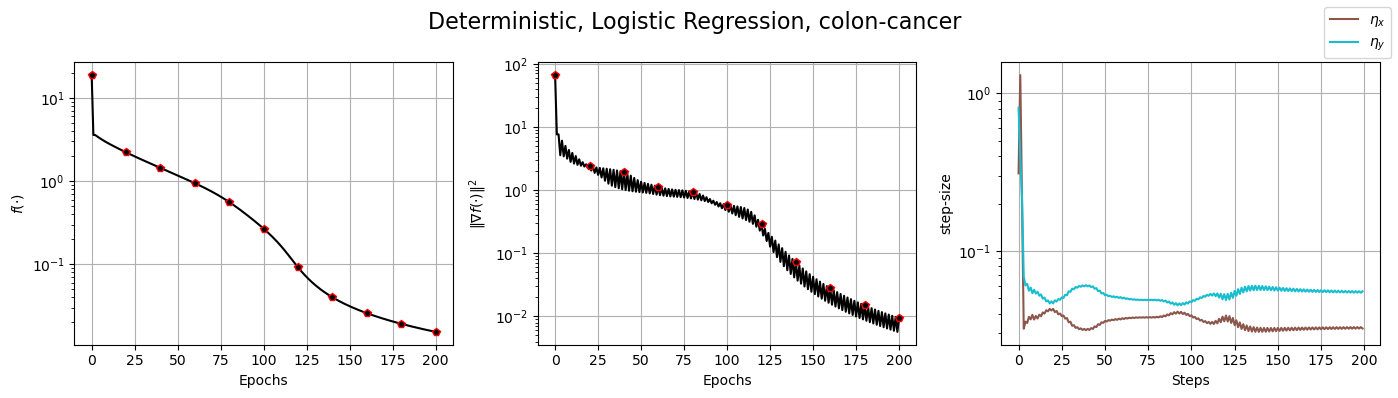

In [647]:
if batch_size == train_data.shape[0]:
        setting = "Deterministic"
else:
        setting = "Stochastic" 
        
        
colors=["black", "red", "tab:blue", "tab:green", "tab:purple"]
linestyles=["-", "--", "-.", ":", "-"]
linewidths=[1.0, 1.0, 2.0, 2.0, 1.0]
markers=["p", ".", "v", "*", "d"]
f_star=0.0
suptitle=f"{setting}, Logistic Regression, {dataset_name}"
threshold=0.0
        
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle(suptitle, fontsize=16)

for history in histories:
        try:
                markevery = [x + np.random.randint(0, 1) for x in range(0, len(history["test/loss"]), len(history["test/loss"]) // 10)]
        except:
                markevery = []

        ax[0].semilogy(history["train/loss"], linestyle="-", color="black", markeredgecolor="red", markevery=markevery, marker="p")
        ax[1].semilogy(history["train/grad_norm_sq"], linestyle="-", color="black", markeredgecolor="red", markevery=markevery, marker="p")
        ax[2].semilogy(history["lr_x"], linestyle="-", color="tab:brown", label=r"$\eta_x$")
        ax[2].semilogy(history["lr_y"], linestyle="-", color="tab:cyan", label=r"$\eta_y$")
        # ax[2].semilogy(history["lr"], linestyle=":", color="tab:blue")

ax[0].set_ylabel(r"$f(\cdot)$")
ax[1].set_ylabel(r"$\| \nabla f(\cdot) \|^2$")
ax[2].set_ylabel("step-size")

ax[0].set_xlabel("Epochs")
ax[1].set_xlabel("Epochs")
ax[2].set_xlabel("Steps")

fig.legend()
ax[0].grid()
ax[1].grid()
ax[2].grid()

fig.tight_layout()

In [669]:
n_epochs = 200
seed = 0

histories = []
labels = []

hist_sgd = train_loop(dataset=dataset, 
                batch_size=batch_size, 
                n_epochs=n_epochs, 
                optimizer=SGD,
                seed=seed, 
                lr=1/L,
                )
histories.append(hist_sgd)
if batch_size == train_data.shape[0]:
        labels.append("GD 1/L")
else:
        labels.append("SGD 1/L")
        
for eta_max in [0.1, 1.0, 2.0, 3.0]:
        hist_sps = train_loop(dataset=dataset, 
                        batch_size=batch_size, 
                        n_epochs=n_epochs, 
                        optimizer=SPS,
                        seed=seed,
                        eta_max=eta_max,
                        eps=1e-10,
                        )
        histories.append(hist_sps)
        labels.append(r"$SPS_{{max}} \gamma={0}$".format(eta_max))

hist_twin = twin_polyak(dataset=dataset,
                       batch_size=batch_size,
                       n_epochs=n_epochs)

histories.append(hist_twin)
labels.append(r"$Twin Polyak$")

if batch_size == train_data.shape[0]:
        setting = "Deterministic"
else:
        setting = "Stochastic" 

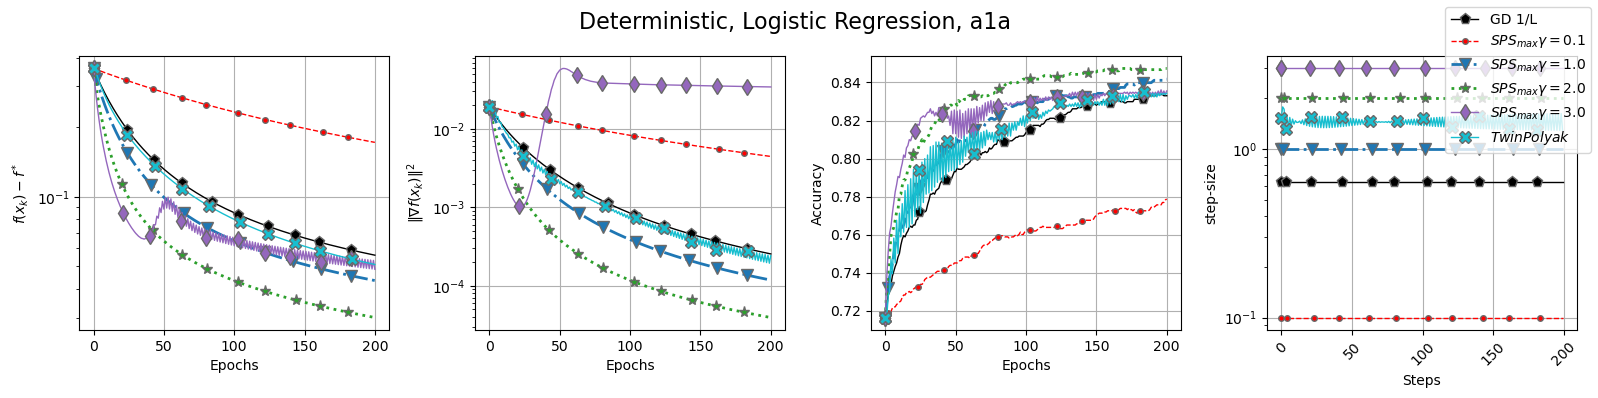

In [670]:
plotter(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0],
        markers=["p", ".", "v", "*", "d", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
        f_star=train_f_star, 
        suptitle=f"{setting}, Logistic Regression, {dataset_name}",
        prefix="train",
        threshold=0.0,
        # filename=f"rand_{dataset_name}_{setting.lower()}_logreg.pdf",
        )

In [723]:
def mean_max_min(l):
    max_length = max(len(sublist) for sublist in l)
    
    mean_line = []
    for i in range(max_length):
        values_at_position = [sublist[i] for sublist in l if i < len(sublist)]
        mean_line.append(np.mean(values_at_position))
        
    max_line = []
    for i in range(max_length):
        values_at_position = [sublist[i] for sublist in l if i < len(sublist)]
        max_line.append(np.max(values_at_position))
        
    min_line = []
    for i in range(max_length):
        values_at_position = [sublist[i] for sublist in l if i < len(sublist)]
        min_line.append(np.min(values_at_position))
        
    return mean_line, max_line, min_line

def plotter_seeds(histories, labels, colors=None, linestyles=None, 
            linewidths=None, markers=None, markeredgecolor=None, markersize=8,
            alphas=None, f_star=None, suptitle=None, prefix="train",
            x_labels=None, y_labels=None,
            threshold=1e-10, xlims=None, tight_layout=True, filename=None):
    
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for x in histories]
    
    if linewidths is None:
        linewidths = [1.5 for x in histories]
        
    if markers is None:
        markers = [" " for x in histories]
    
    if alphas is None:
        alphas = [1.0 for x in histories]
    
    for history, label, c, ls, lw, m, alpha in zip(histories, labels, colors, linestyles, linewidths, markers, alphas):
        if not f_star:
            f_suboptim = [x[f"{prefix}/loss"] for x in history]
        else:
            f_suboptim = [x[f"{prefix}/loss"] - f_star for x in history]
            
        mean_line, max_line, min_line = mean_max_min(f_suboptim)
        x = np.linspace(0, len(mean_line) - 1, len(mean_line))
        markevery = [0,] + [x + np.random.randint(0, 3) for x in range(0, len(mean_line) - 2, len(mean_line) // 10)]
        ax[0].fill_between(x, max_line, min_line, color=c, alpha=0.2) 
        ax[0].semilogy(x, mean_line, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
            


        grad_norm_sq = [x[f"{prefix}/grad_norm_sq"] for x in history]
        mean_line, max_line, min_line = mean_max_min(grad_norm_sq)
        x = np.linspace(0, len(mean_line) - 1, len(mean_line))
        ax[1].fill_between(x, max_line, min_line, color=c, alpha=0.2) 
        ax[1].semilogy(x, mean_line, linestyle=ls, linewidth=lw, color=c, label=label, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)

        
        acc = [x[f"{prefix}/acc"] for x in history]
        mean_line, max_line, min_line = mean_max_min(acc)
        x = np.linspace(0, len(mean_line) - 1, len(mean_line))
        ax[2].fill_between(x, max_line, min_line, color=c, alpha=0.2) 
        ax[2].plot(x, mean_line, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        
        
        lrs = [x[f"lr"] for x in history]
        mean_line, max_line, min_line = mean_max_min(lrs)
        x = np.linspace(0, len(mean_line) - 1, len(mean_line))
        markevery = [0,] + [x + np.random.randint(0, 3) for x in range(0, len(mean_line) - 2, len(mean_line) // 10)]
        ax[3].fill_between(x, max_line, min_line, color=c, alpha=0.2) 
        ax[3].semilogy(x, mean_line, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)

        # if alpha != 1.0:
        #     ax[3].semilogy(history["lr"], linestyle=ls, linewidth=lw, color=c, alpha=alpha)
        #     ax[3].semilogy(moving_average(history["lr"], 100), linestyle=ls, linewidth=lw, color=c, alpha=1.0, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        # else:
        #     ax[3].semilogy(history["lr"], linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)

    if f_star == 0.0:
        ax[0].set_ylabel(r"$f(x_k)$")
        ax[1].set_ylabel(r"$\| \nabla f(x_k) \|^2$")
    else:
        ax[0].set_ylabel(r"$f(x_k) - f^*$")
        ax[1].set_ylabel(r"$\| \nabla f(x_k) \|^2$")
        
    ax[2].set_ylabel("Accuracy")
    ax[3].set_ylabel("step-size")
    
    ax[0].set_xlabel("Epochs")
    ax[1].set_xlabel("Epochs")
    ax[2].set_xlabel("Epochs")
    ax[3].set_xlabel("Steps")
    
    # ax[3].tick_params(axis='x', rotation=45)


    if xlims is not None:
        ax[1].set_xlim(right=xlims[1])
    
    fig.legend()
    # # Put a legend below current axis
    # fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
    #       fancybox=True, shadow=True, ncol=len(histories))
    
    
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    ax[3].grid()

    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        directory = "experiments/plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
        if not os.path.exists(directory):
            os.makedirs(directory)
        fig.savefig(directory + "/" + filename)
    else:
        fig.show()
        
def plotter_seeds_2(histories, labels, colors=None, linestyles=None, 
            linewidths=None, markers=None, markeredgecolor=None, markersize=8,
            alphas=None, suptitle=None, prefix="train", tight_layout=True, filename=None):
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for x in histories]
    
    if linewidths is None:
        linewidths = [1.5 for x in histories]
        
    if markers is None:
        markers = [" " for x in histories]
    
    if alphas is None:
        alphas = [1.0 for x in histories]
    
    for history, label, c, ls, lw, m, alpha in zip(histories, labels, colors, linestyles, linewidths, markers, alphas):
        
        grad_norm_sq = [x[f"{prefix}/grad_norm_sq"] for x in history]
        mean_line, max_line, min_line = mean_max_min(grad_norm_sq)
        x = np.linspace(0, len(mean_line) - 1, len(mean_line))
        markevery = [0,] + [x + np.random.randint(0, 3) for x in range(0, len(mean_line) - 2, len(mean_line) // 10)]
        ax[0].fill_between(x, max_line, min_line, color=c, alpha=0.2) 
        ax[0].semilogy(x, mean_line, linestyle=ls, linewidth=lw, color=c, label=label, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        
        lrs = [x[f"lr"] for x in history]
        mean_line, max_line, min_line = mean_max_min(lrs)
        x = np.linspace(0, len(mean_line) - 1, len(mean_line))
        markevery = [0,] + [x + np.random.randint(0, 3) for x in range(0, len(mean_line) - 2, len(mean_line) // 10)]
        ax[1].fill_between(x, max_line, min_line, color=c, alpha=0.2) 
        ax[1].semilogy(x, mean_line, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)

        # if alpha != 1.0:
        #     ax[3].semilogy(history["lr"], linestyle=ls, linewidth=lw, color=c, alpha=alpha)
        #     ax[3].semilogy(moving_average(history["lr"], 100), linestyle=ls, linewidth=lw, color=c, alpha=1.0, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        # else:
        #     ax[3].semilogy(history["lr"], linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)

    ax[0].set_ylabel(r"$\| \nabla f(x_k) \|^2$")
    ax[1].set_ylabel("step-size")
    
    ax[0].set_xlabel("Epochs")
    ax[1].set_xlabel("Steps")
    
    fig.legend()
    
    ax[0].grid()
    ax[1].grid()
    
    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        directory = "experiments/plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
        if not os.path.exists(directory):
            os.makedirs(directory)
        fig.savefig(directory + "/" + filename)
    else:
        fig.show()

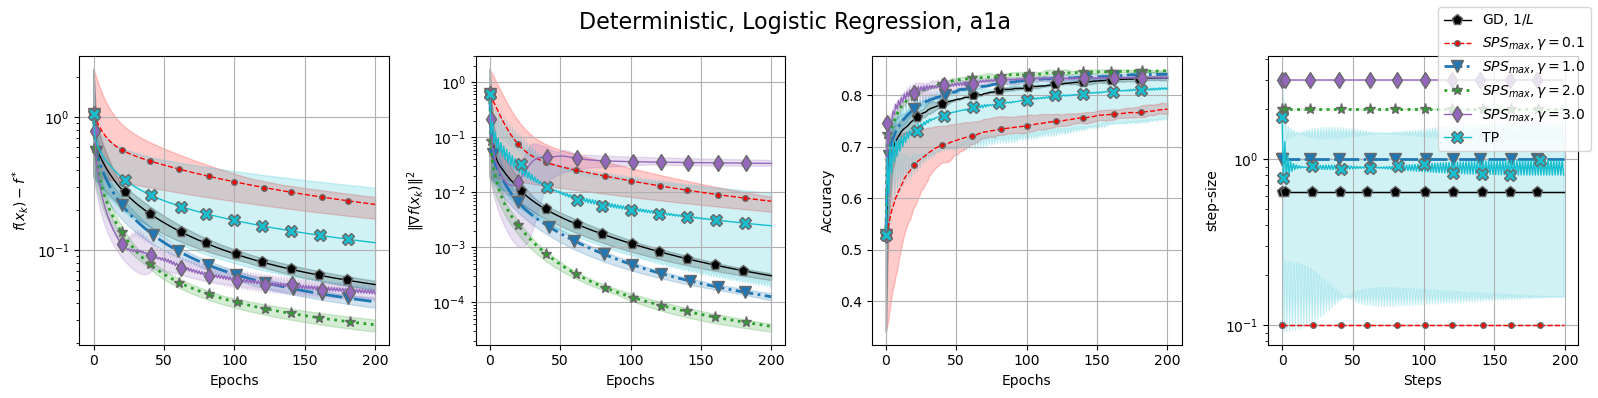

In [725]:
setting = "deterministic"
dataset_name = "a1a"

histories = []
labels = []

seed_results = []
for seed in range(5):
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=0,
                                n_epochs=200,
                                optimizer="SGD-L",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append(r"GD, $1/L$")
else:
    labels.append(r"SGD, $1/L$")

for eta_max in [0.1, 1.0, 2.0, 3.0]:
    seed_results = []
    for seed in range(5):
        results = utils.load_results(loss="logreg", 
                                    setting=setting, 
                                    dataset_name=dataset_name,
                                    batch_size=0,
                                    n_epochs=200,
                                    optimizer=f"SPSMAX_{eta_max}".replace(".", "_"),
                                    lr="1_0",
                                    seed=seed
                                    )
        
        seed_results.append(results)
    histories.append(seed_results)
    labels.append(r"$SPS_{{max}}, \gamma={0}$".format(eta_max))


seed_results = []
for seed in range(5):
    results = utils.load_results(loss="logreg", 
                                setting=setting, 
                                dataset_name=dataset_name,
                                batch_size=0,
                                n_epochs=200,
                                optimizer="STP",
                                lr="1_0",
                                seed=seed
                                )
    
    seed_results.append(results)
histories.append(seed_results)
if setting == "deterministic":
    labels.append("TP")
else:
    labels.append("STP")


with open(f"experiments/solver/{dataset_name}_sol.pkl", "rb") as file:
    b = pickle.load(file)
    train_f_star = b["train/f_star"]

plotter_seeds(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0],
        markers=["p", ".", "v", "*", "d", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
        f_star=train_f_star, 
        suptitle=f"{setting.capitalize()}, Logistic Regression, {dataset_name}",
        prefix="train",
        threshold=0.0,
        # filename=f"{dataset_name}_{setting.lower()}_logreg.pdf",
        )

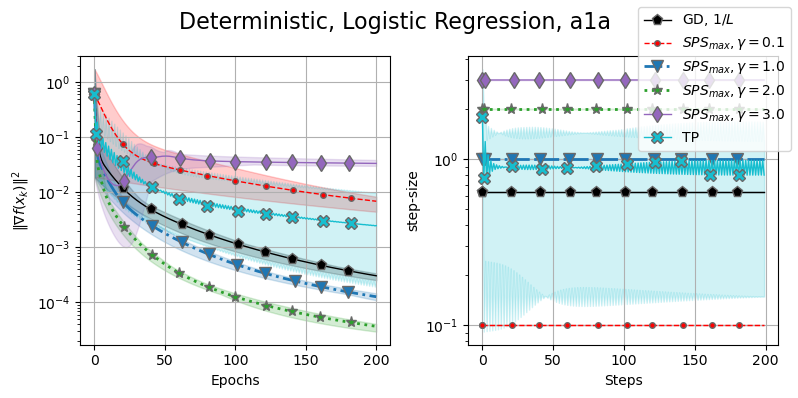

In [726]:
plotter_seeds_2(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0],
        markers=["p", ".", "v", "*", "d", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
        suptitle=f"{setting.capitalize()}, Logistic Regression, {dataset_name}",
        prefix="train",
        # filename=f"{dataset_name}_{setting.lower()}_logreg.pdf",
        )

In [715]:
for i in range(len(histories)):
    print(histories[i][4]["train/loss"][0])

1.0156750005770663
0.6569050922253892
0.6569050922253892
0.6569050922253892
0.6569050922253892
1.0156750005770663


In [126]:
def twin_model_moving_average(dataset: list[np.ndarray], 
               batch_size: int, 
               n_epochs: int,
               seed: int = 0
               ) -> dict: 
    
    np.random.seed(seed)

    train_data, train_target, test_data, test_target = dataset
    
    # parameters
    params_x = np.random.randn(train_data.shape[1])
    params_y = np.random.randn(train_data.shape[1])

    # oracle 
    loss_function = LogisticRegressionLoss()
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    # Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params_x, test_data, test_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["test/loss"].append(loss)
    history["test/acc"].append(acc)
    history["test/grad_norm_sq"].append(g_norm_sq)
    
    fx_m = 0.0
    fy_m = 0.0
    gx_m = np.zeros_like(params_x)
    gy_m = np.zeros_like(params_y)

    m = 0.9
    eps = 0.0
    for epoch in range(n_epochs):
    
        # Training 
        if batch_size != train_data.shape[0]:
            np.random.shuffle(indices)

        for idx in range(train_data.shape[0]//batch_size):
            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
            
            train_loss_x, train_grad_x, _ = loss_function.func_grad_acc(params_x, batch_data, batch_target)
            train_loss_y, train_grad_y, _  = loss_function.func_grad_acc(params_y, batch_data, batch_target)
            
            print(f"{fx_m=}, {fy_m=}")
            
            if train_loss_x < train_loss_y:
                fy_m = (1 - m) * fy_m + m * train_loss_y
                gy_m = (1 - m) * gy_m + m * train_grad_y
                
                lr =  (fy_m - fx_m) / (0.5 * np.linalg.norm(gy_m)**2 + eps)
                params_y -= lr * train_grad_y
            else:
                fx_m = (1 - m) * fx_m + m * train_loss_x
                gx_m = (1 - m) * gx_m + m * train_grad_x
            
                lr =  (fx_m - fy_m) / (0.5 * np.linalg.norm(gx_m)**2 + eps)
                params_x -= lr * train_grad_x
                
            
            history["batch/lr"].append(lr)
        
        # Evaluation 
        loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, test_data, test_target)
        loss_y, grad_y, acc_y = loss_function.func_grad_acc(params_y, test_data, test_target)
        
        if loss_x < loss_y:
            g_norm_sq = np.linalg.norm(grad_x)**2
            history["test/loss"].append(loss_x)
            history["test/acc"].append(acc_x)
            history["test/grad_norm_sq"].append(g_norm_sq)
        else:
            g_norm_sq = np.linalg.norm(grad_y)**2
            history["test/loss"].append(loss_y)
            history["test/acc"].append(acc_y)
            history["test/grad_norm_sq"].append(g_norm_sq)

    
    return history

In [127]:
n_epochs = 100
seed = 0

histories = []
labels = []

# hist_sgd = train_loop(dataset=dataset, 
#                 batch_size=batch_size, 
#                 n_epochs=n_epochs, 
#                 optimizer=SGD,
#                 seed=seed, 
#                 lr=1/L,
#                 )
# histories.append(hist_sgd)
# if batch_size == train_data.shape[0]:
#         labels.append("GD 1/L")
# else:
#         labels.append("SGD 1/L")
        
# for eta_max in [0.1, 10.0]:
#         hist_sps = train_loop(dataset=dataset, 
#                         batch_size=batch_size, 
#                         n_epochs=n_epochs, 
#                         optimizer=SPS,
#                         seed=seed,
#                         eta_max=eta_max
#                         )
#         histories.append(hist_sps)
#         labels.append(r"$SPS_{{max}} \gamma_b={0}$".format(eta_max))

hist_twin = twin_model(dataset=dataset,
                       batch_size=batch_size,
                       n_epochs=n_epochs)
histories.append(hist_twin)
labels.append(r"$Twin Polyak$")

hist_twin_ma = twin_model_moving_average(dataset=dataset,
                       batch_size=batch_size,
                       n_epochs=n_epochs)
histories.append(hist_twin_ma)
labels.append("Twin Polyak with Moving Averages")

if batch_size == train_data.shape[0]:
        setting = "Deterministic"
else:
        setting = "Stochastic" 

fx_m=0.0, fy_m=0.0
fx_m=1.1450828896148222, fy_m=0.0
fx_m=0.8816026358150496, fy_m=0.0
fx_m=0.8816026358150496, fy_m=0.9255718818427908
fx_m=0.8816026358150496, fy_m=0.8407762299667718
fx_m=0.8816026358150496, fy_m=0.9106800836362385
fx_m=0.8816026358150496, fy_m=0.9953137592148105
fx_m=0.8816026358150496, fy_m=0.7819454998740313
fx_m=0.8816026358150496, fy_m=0.8317790213211675
fx_m=0.8816026358150496, fy_m=1.06565757186918
fx_m=0.8816026358150496, fy_m=0.8405772922139849
fx_m=0.8816026358150496, fy_m=0.9561777105704918
fx_m=0.8816026358150496, fy_m=0.8023167368502391
fx_m=0.8816026358150496, fy_m=0.7713668206925515
fx_m=0.8816026358150496, fy_m=0.9924630956490691
fx_m=0.8816026358150496, fy_m=0.9002277033201711
fx_m=0.8816026358150496, fy_m=0.9269741562531272
fx_m=0.8816026358150496, fy_m=0.7979212995584761
fx_m=0.8816026358150496, fy_m=0.9696407614023516
fx_m=0.8816026358150496, fy_m=0.7914196397929534
fx_m=0.8816026358150496, fy_m=0.8968596983950515
fx_m=0.8816026358150496, fy_m=0.8

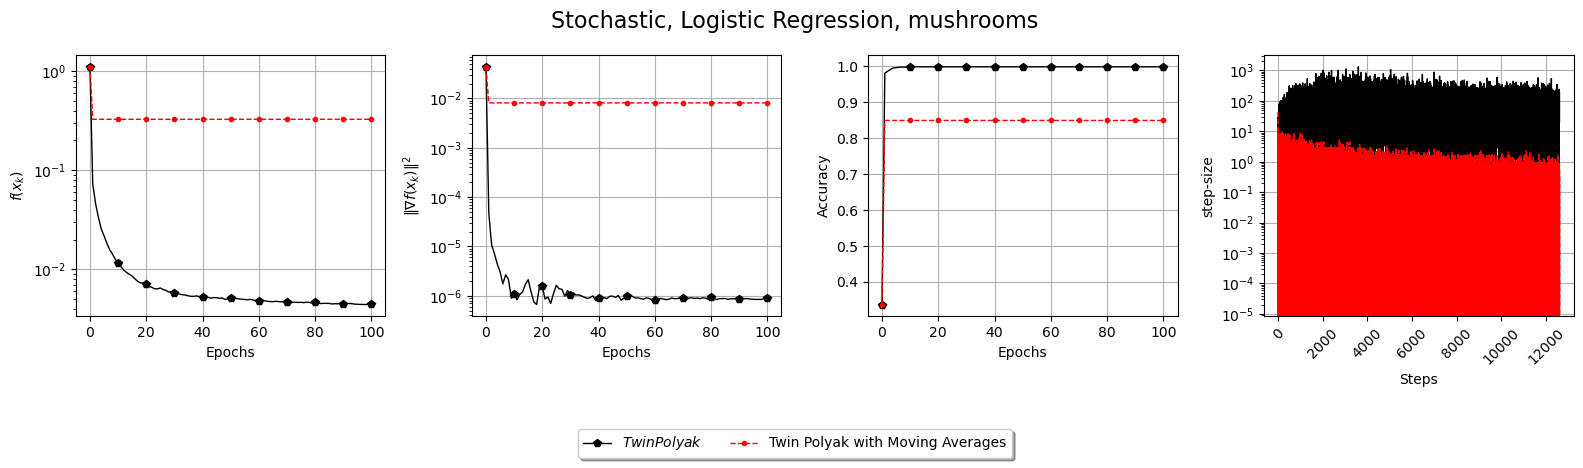

In [128]:
plotter(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0],
        markers=["p", ".", "v", "*", "d", "X"],
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 0.6],
        f_star=0.0, 
        suptitle=f"{setting}, Logistic Regression, {dataset_name}",
        threshold=0.0,
        # filename=f"rand_{dataset_name}_{setting.lower()}_logreg.pdf",
        )

fx_m=0.0, fy_m=0.0
fx_m=0.0, fy_m=20.422569565529326
fx_m=0.0, fy_m=17.587771620128436
fx_m=0.0, fy_m=16.824698004063155
fx_m=0.0, fy_m=15.377209911813356
fx_m=0.0, fy_m=14.747988103967076
fx_m=0.0, fy_m=12.817605424482988
fx_m=0.0, fy_m=13.476137552913972
fx_m=0.0, fy_m=11.927816114674501
fx_m=0.0, fy_m=13.484714024120098
fx_m=0.0, fy_m=12.35343354405764
fx_m=0.0, fy_m=13.420932874609738
fx_m=0.0, fy_m=12.920665857546739
fx_m=0.0, fy_m=14.473587189764787
fx_m=0.0, fy_m=13.507380618156267
fx_m=0.0, fy_m=15.052284784033223
fx_m=0.0, fy_m=14.670782465345333
fx_m=0.0, fy_m=15.370738084393373
fx_m=0.0, fy_m=14.956736088265334
fx_m=0.0, fy_m=15.987471575744888
fx_m=0.0, fy_m=15.624162085312225
fx_m=0.0, fy_m=16.81218468782581
fx_m=0.0, fy_m=16.57173489118529
fx_m=0.0, fy_m=17.16622860976666
fx_m=0.0, fy_m=17.59964665967972
fx_m=0.0, fy_m=17.96027098915546
fx_m=0.0, fy_m=17.052196649678354
fx_m=0.0, fy_m=18.99108971933189
fx_m=0.0, fy_m=17.74167228943874
fx_m=0.0, fy_m=19.316119857719293
fx_

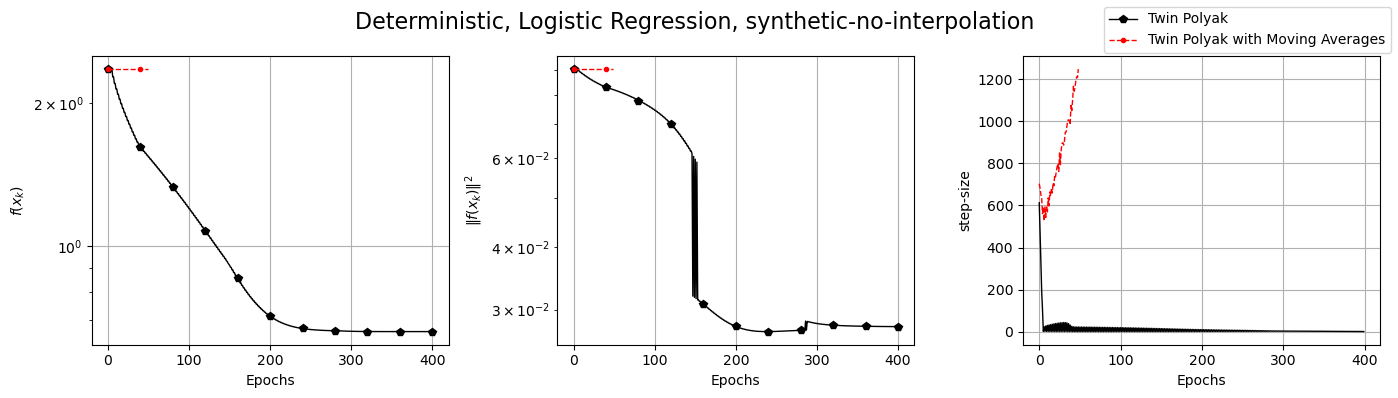

In [67]:
n_epochs = 400
seed = 0

histories = []
labels = []

# hist_sgd = train_loop(dataset=dataset, 
#                 batch_size=batch_size, 
#                 n_epochs=n_epochs, 
#                 optimizer=SGD,
#                 seed=seed, 
#                 lr=1/L,
#                 )
# histories.append(hist_sgd)
# if batch_size == train_data.shape[0]:
#         labels.append("GD 1/L")
# else:
#         labels.append("SGD 1/L")
        
# hist_sps = train_loop(dataset=dataset, 
#                 batch_size=batch_size, 
#                 n_epochs=n_epochs, 
#                 optimizer=SPS,
#                 seed=seed
#                 )
# histories.append(hist_sps)
# labels.append("SPS")

hist_twin = twin_model(dataset=dataset,
                       batch_size=batch_size,
                       n_epochs=n_epochs)
histories.append(hist_twin)
labels.append("Twin Polyak")

hist_twin = twin_model_moving_average(dataset=dataset,
                       batch_size=batch_size,
                       n_epochs=n_epochs)
histories.append(hist_twin)
labels.append("Twin Polyak with Moving Averages")

if batch_size == train_data.shape[0]:
        setting = "Deterministic"
else:
        setting = "Stochastic" 

plotter(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple"],
        linestyles=["-", "--", "-.", ":", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0],
        markers=["p", ".", "v", "v", "p"],
        f_star=0.0, 
        suptitle=f"{setting}, Logistic Regression, {dataset_name}",
        threshold=0.0)